In [1]:
import pandas as pd
import math
import numpy as np 
import matplotlib.pyplot as plt

In [11]:
# Helper functions.
get_score_from_choice_df = lambda t: t.values[0][1]

def create_sorted_attribute_df(original_df, attribute):
    return original_df.sort_values(attribute, ignore_index=True)[["county_name", attribute]]

def apply_func(df, func, state):
    res = df.copy(deep=True)
    for q in questions:
        ques = q["q"]
        obj = get_metric_class(state)
        base = get_base_df(state, q['attr'])
        
        if q["target"] == "max":
            target = base.tail(1).values[0][0]
        elif q["target"] == "min":
            target = base.head(1).values[0][0]
        res[ques] = df[ques].apply(lambda x: func(obj, x, target))
    return res

def get_base_df(state, attr):
    if attr not in base_df[state].keys():
        df = pd.read_json(metadata[state]["state_data"])
        base_df[state][attr] = create_sorted_attribute_df(df, attr)
    return base_df[state][attr]
        
def get_metric_class(state):
    if not metric_obj[state]:
        metric_obj[state] = CS(metadata[state]['coordinates'])
    return metric_obj[state]

In [3]:
def calculate_cs_score(metric_obj, selected, target, radius=0.5):
    return metric_obj.get_metric(selected, target, radius)

In [67]:
class CS():
    
    def __init__(self, path):
        self.data = pd.read_json(path).rename(columns={"textFloater": "id"}).set_index("id")
        
    def get_counties(self):
        
        ret = []
        for county, row in self.data.iterrows():
            ret.append(county)
        return ret
    
    def get_data(self):
        return self.data
    
    def get_county_coord(self, county_name):
        return self.data.loc[county_name]["coordinates"]
    
    def get_x(self, county_name):
        return self.get_county_coord(county_name)['x']
    
    def get_y(self, county_name):
        return self.get_county_coord(county_name)['y']
    
    def hyp(self, c1, c2):
        return math.sqrt((self.get_x(c1) - self.get_x(c2))**2 + (self.get_y(c1) - self.get_y(c2))**2)
    
    def union(self, lst1, lst2):
        return list(set(lst1) | set(lst2))
    
    def get_in_r(self, county, radius):
        resp = []
        
        for c_id, row in self.data.iterrows():
            if county == c_id:
                continue
            if self.hyp(county, c_id) < radius:
                resp.append(c_id)
        return resp
    
    def get_metric(self, selected, target, radius):
#         if selected == target:
#             print(selected, target, 500)
#             return 500
        lst1 = self.get_in_r(selected, radius)
        lst2 = self.get_in_r(target, radius)
        
        l = len(self.union(lst1, lst2))
        h = self.hyp(selected, target) + 1
        
        score = l / h
        print(selected, target, score)
        return score

In [68]:
attributes = ['age_median', 'white_ratio', 'income_per_capita']
base_df = {"NY": {}, "CA": {}}
metric_obj = {"NY": None, "CA": None}
questions = [ {"q": "Find the RICHEST county (highest income per capita).", "attr": "income_per_capita", "target": "max"}
            , {"q":"Find the POOREST county (lowest income per capita).", "attr": "income_per_capita", "target": "min"}
            , {"q":"Find the OLDEST county (highest age median).", "attr": "age_median", "target": "max"}
            , {"q":"Find the YOUNGEST county (lowest age median).", "attr": "age_median", "target": "min"}
            , {"q":"Find the WHITEST county (highest white ratio).", "attr": "white_ratio", "target": "max"}
            , {"q":"Find the most RACIALLY DIVERSE county (lowest white ratio).", "attr": "white_ratio", "target": "min"}
#             , {"q":"Find the OVERALL MOST AVERAGE county (a county that is most average by some/all criteria).", "attr": base_df[2], "target": True}
#             , {"q":"Find the OVERALL MOST OUTLYING county (a county that is least average by some/all criteria).", "attr": base_df[2], "target": True}
            ]

In [69]:
metadata = {
    "CA": {
        "graph": "radviz",
        "responces": './Responses/Radviz Survey (Responses).csv',
        "state_data": '../public/radvizData/caDem.json',
        "coordinates": './DataCoordinates/ca_coordniates.json',
    },
    "NY": {
        "graph": "sradviz",
        "responces": './Responses/S-Radviz Survey (Responses).csv',
        "state_data": '../public/radvizData/nyDem.json',
        "coordinates": './DataCoordinates/ny_coordinates.json',
    }
}

San Francisco County Marin County 6.513440453602138
San Francisco County Marin County 6.513440453602138
Alameda County Marin County 5.664227048939881
Alameda County Marin County 5.664227048939881
San Francisco County Marin County 6.513440453602138
Alameda County Marin County 5.664227048939881
Alameda County Marin County 5.664227048939881
Yolo County Lassen County 19.010519922879524
Del Norte County Lassen County 31.628644118450705
Del Norte County Lassen County 31.628644118450705
Del Norte County Lassen County 31.628644118450705
Trinity County Lassen County 21.304288444212645
Contra Costa County Lassen County 20.29491568003185
Marin County Lassen County 18.611719736156722
Alpine County Sierra County 10.685982401496544
Alpine County Sierra County 10.685982401496544
Yolo County Sierra County 13.712989498049062
Alpine County Sierra County 10.685982401496544
Alpine County Sierra County 10.685982401496544
Alpine County Sierra County 10.685982401496544
Alpine County Sierra County 10.68598240

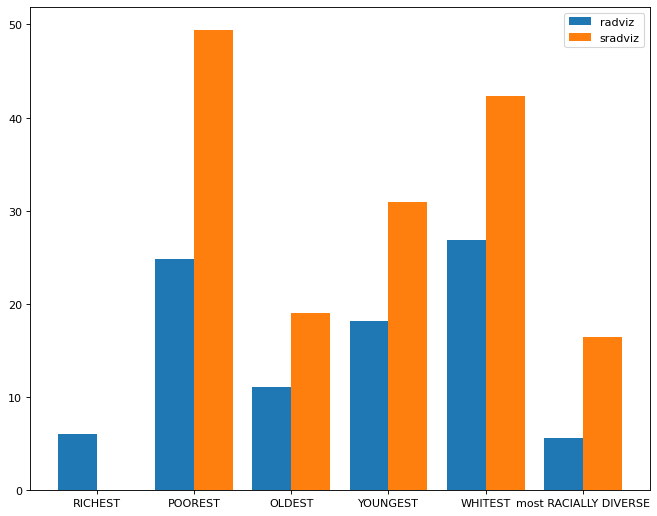

In [70]:
# Define Data
quest = list(map(lambda x: x["q"], questions))
x_axis = np.arange(len(quest))
offset = -0.2

# Add size
plt.figure(figsize=(10, 8), dpi=80)

for state in metadata.keys():

    responses = pd.read_csv(metadata[state]["responces"])

    g_data = apply_func(responses, calculate_cs_score, state)[list(map(lambda x: x["q"], questions))].mean(axis=0).values

    # Multi bar Chart
    plt.bar(x_axis + offset, g_data, width=0.4, label = metadata[state]['graph'])
    offset += 0.4
    
# Xticks
lebels = []
for q in quest:
    start = 9
    end = q.index("(") - len("county  ")
    lebels.append(q[start:end])
plt.xticks(x_axis, lebels)

# Add legend
plt.legend()

# Display
plt.show()